# Importing python modules

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import deque

# Import video tools
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Helpers

In [103]:
# Plotting
class NamedImage:
    img = np.empty([0,0,0])
    name = ''
    
    def __init__(self, img, name):
        self.img = img
        self.name = name

def plot_multiple(plot_img_list):
    ncol = 2
    nrow = int(np.ceil(len(plot_img_list)/ncol))

    f, axes = plt.subplots(nrow, ncol, figsize=(96,36), squeeze=False)
    f.tight_layout()

    for idx, named_img in enumerate(plot_img_list):
        selected_row = int(idx / ncol)
        selected_col = int(idx % ncol)
        axes[selected_row, selected_col].imshow(named_img.img)
        axes[selected_row, selected_col].set_title(named_img.name, fontsize=14)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., wspace=0.)

# Gaussian Blur
def gaussian_smoothing(img, kernel_size=3):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# ROI Mask
def binary_mask(img, vertices):
    mask = np.zeros_like(img)   

    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def combine_img(init_img, img, alpha=0.8, beta=1., gamma=0.):
    return cv2.addWeighted(init_img, alpha, img, beta, gamma)

class Line():
    def __init__(self, coeffs=np.array([0,0,0]), valid=True, x_pix=None, y_pix=None):
        self.coeffs = coeffs
        self.x_pix = x_pix
        self.y_pix = y_pix
        self.valid = True
        
    def radius_pix(self, y_eval):
        return ((1 + (2*self.coeffs[0]*y_eval \
                      + self.coeffs[1])**2)**(1.5)) \
                      / np.absolute(2*self.coeffs[0])
        
    def radius_m(self, y_eval=720, ym_per_pix=(30/720), xm_per_pix=(3.7/700)):
        return ((1 + (2*self.coeffs[0]*y_eval*ym_per_pix \
                      + self.coeffs[1])**2)**1.5) \
                      / np.absolute(2*self.coeffs[0])
        
    def f(self, y_eval):
        return self.coeffs[0]*y_eval**2 + self.coeffs[1]*y_eval + self.coeffs[2]

class LineHist():
    def __init__(self, histSize= 5):
        self.histSize = histSize
        self.hist_left = deque([Line(valid=False)], maxlen=histSize)
        self.hist_right = deque([Line(valid=False)], maxlen=histSize)
        
    def appendLines(self, line_left, line_right, curvature_thresh=0.05):
        if self.sanityCheck(line_left, line_right, curvature_thresh):
            self.hist_left.appendleft(line_left)
            self.hist_right.appendleft(line_right)
        else:
            self.hist_left.appendleft(Line(valid=False))
            self.hist_right.appendleft(Line(valid=False))
        
    def sanityCheck(self,
                    line_left,
                    line_right,
                    curvature_thresh=0.05,
                    dist_thresh=(1.5, 2.5),
                    var_thresh=1.0,
                    img_height=720,
                    xm_per_pix=(3.7/700)):
        
        checkResult = True
        
        # check if the lines have similar curvature
        left_rad = line_left.radius_m()
        right_rad = line_right.radius_m()
        if not (np.absolute(left_rad - right_rad) / left_rad) <= curvature_thresh:
            checkResult = False
            
        # check if the lines fit to the current average line
        avgLineRad = self.getAverageMiddleLine().radius_m()
        if not (((np.absolute(left_rad - avgLineRad) / left_rad) <= curvature_thresh) \
            & ((np.absolute(right_rad - avgLineRad) / right_rad) <= curvature_thresh)):
            checkResult = False
            
        # check if average distance between the lines is ok
        dist_vect = xm_per_pix * line_left.f(np.linspace(0, img_height-1, img_height)) \
                                        - line_right.f(np.linspace(0, img_height-1, img_height))
        mean_dist = np.mean(dist_vect)    
        if (mean_dist > dist_thresh[1]) | (mean_dist < dist_thresh[0]):
            checkResult = False
        
        # check if the lines are parallel
        dist_variance = np.var(dist_vect)
        if dist_variance > var_thresh:
            checkResult = False
        
        return checkResult
        
    def getAverageMiddleLine(self):
        coeff_avg = []
        for line in self.hist_left:
            if line.valid:
                coeff_avg = np.append(coeff_avg, line.coeffs)
        for line in self.hist_right:
            if line.valid:
                coeff_avg = np.append(coeff_avg, line.coeffs)

        coeff_avg = np.vstack(coeff_avg)
        return Line(np.mean(coeff_avg, axis=1))
    
    def getAverageLines(self):
        coeff_avg_left = np.array([])
        coeff_avg_right = np.array([])
        
        for line in self.hist_left:
            if line.valid:
                coeff_avg_left = np.append(coeff_avg_left, line.coeffs)
        coeff_avg_left = np.vstack(coeff_avg_left)
        left_line = Line(np.mean(coeff_avg_left, axis=1))
        
        for line in self.hist_right:
            if line.valid:
                coeff_avg_right = np.append(coeff_avg_right, line.coeffs)
        coeff_avg_right = np.vstack(coeff_avg_right)
        right_line = Line(np.mean(coeff_avg_right, axis=1))
        
        return left_line, right_line

# Camera Calibration

In [16]:
# Number of corners in x and y direction
nx = 9
ny = 6

def cal_get_calib_params():
    cal_img_path = "./camera_cal"        
    img_points = []
    obj_points = []

    # Object points
    objp_template = np.zeros((nx*ny, 3), np.float32)
    objp_template[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        
    for imgName in os.listdir(cal_img_path):
        #load the image
        img = cv2.imread(os.path.join(cal_img_path, imgName))
        # convert ot grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp_template)
    return img_points, obj_points
        
def cal_undistort(img_points, obj_points, img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Color Space Thresholding

In [17]:
def cst_threshold(img, channel='S', thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    if channel == 'H':
        single_channel = hls[:,:,0]
    elif channel == 'L':
        single_channel = hls[:,:,1]
    elif channel == 'S':
        single_channel = hls[:,:,2]
    binary_output = np.zeros_like(single_channel)
    binary_output[(single_channel > thresh[0]) & (single_channel <= thresh[1])] = 1
    return binary_output

# Gradient Thresholding

In [18]:
def grad_mag_thresh(img, sobel_kernel=5, thresh=(0, 255)):
    # if the image is a color image, then first convert it to gray
    if len(img.shape) > 1:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # calculate the gradient magnitude
    mag = np.sqrt(sobel_x**2 + sobel_y**2)
    # scale to a range between 0 and 255
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    
    # apply the threshold and create a binary output image
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary

In [19]:
def grad_dir_thresh(img, sobel_kernel=5, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)

    directions = np.arctan2(sobely_abs, sobelx_abs)

    binary = np.zeros_like(directions)
    binary[(directions >= thresh[0]) & (directions <= thresh[1])] = 1

    return binary

# Pipeline for thresholded binary image

In [20]:
# Calibration
img_points, obj_points = cal_get_calib_params()

In [21]:
def line_segmentation(img):
    # Array of images, which is used to store the intermediate results of the pipeline
    plot_img_list = []

    #### Parameters ####
    # Color thresholds
    thresh_cst_h = (90,100)
    thresh_cst_l = (200,255)
    thresh_cst_s = (150,255)

    # Gradient thresholds
    # Magnitude
    thresh_grad_mag = (100,150)
    # Direction
    thresh_grad_dir = (0.7,1.3)

    # Vertices of ROI mask
    x_len = img.shape[1]
    y_len = img.shape[0]
    vertices = np.array([[[0,y_len],
                [int(x_len/2)-30,int(y_len/2)+70],
                [int(x_len/2)+30,int(y_len/2)+70],
                [x_len,y_len]]])

    img_undist = cal_undistort(img_points, obj_points, img)
    plot_img_list.append(NamedImage(img_undist, 'Undistortion'))

    img_undist = gaussian_smoothing(img, kernel_size=5)

    img_color_thresh_H = cst_threshold(img_undist, 'H', thresh_cst_h)
    plot_img_list.append(NamedImage(img_color_thresh_H, 'Color Threshold H'))

    img_color_thresh_L = cst_threshold(img_undist, 'L', thresh_cst_l)
    plot_img_list.append(NamedImage(img_color_thresh_L, 'Color Threshold L'))

    img_color_thresh_S = cst_threshold(img_undist, 'S', thresh_cst_s)
    plot_img_list.append(NamedImage(img_color_thresh_S, 'Color Threshold S'))

    img_grad_mag = grad_mag_thresh(img_undist, 5, thresh_grad_mag)
    plot_img_list.append(NamedImage(img_grad_mag, 'Gradient Magnitude Threshold'))

    img_grad_dir = grad_dir_thresh(img_undist, sobel_kernel=5, thresh=thresh_grad_dir)
    plot_img_list.append(NamedImage(img_grad_dir, 'Gradient Direction Threshold'))

    combined_grad = np.zeros_like(img_grad_dir)
    combined_grad[((img_grad_mag == 1) & (img_grad_dir == 1))] = 1
    plot_img_list.append(NamedImage(combined_grad, 'Combined Gradient Thresholds'))

    combined_col = np.zeros_like(img_color_thresh_H)
    combined_col[((img_color_thresh_H == 1) | (img_color_thresh_L == 1) | (img_color_thresh_S == 1))] = 1
    plot_img_list.append(NamedImage(combined_col, 'Combined Color Thresholds'))

    combined = np.zeros_like(img_color_thresh_H)
    combined[((combined_grad == 1) | (combined_col == 1))] = 1
    plot_img_list.append(NamedImage(combined, 'All Thresholds Combined'))

    img_masked = binary_mask(combined, vertices)
    plot_img_list.append(NamedImage(img_masked, 'ROI Mask Applied'))

    return img_masked, plot_img_list

# Perspective Transform

In [22]:
def perspective_transform(img, inverse=False):
    x_len = img.shape[1]
    y_len = img.shape[0]
    
    src = np.float32([[200,y_len],
                      [595,450],
                      [686,450],
                      [1105,y_len]])
    dst = np.float32([[400,y_len],
                      [400,0],
                      [880,0],
                      [880,y_len]])
    
    #plt.imshow(img)
    #plt.plot(src[0][0],src[0][1], '.')
    #plt.plot(src[1][0],src[1][1], '.')
    #plt.plot(src[2][0],src[2][1], '.')
    #plt.plot(src[3][0],src[3][1], '.')
    
    # in case we want to get the inverse transform, swap src and dst
    if inverse:
        src,dst = dst,src
        
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img.shape[1::-1], flags=cv2.INTER_LINEAR)

    return warped, M

# Finding the Lines

In [23]:
def find_init_line_pos(img):
    bottom_half = img[img.shape[0]//2:, :]

    hist = np.sum(bottom_half, axis = 0)

    middle = np.int(hist.shape[0]//2)
    
    x_left = np.argmax(hist[:middle])
    x_right = np.argmax(hist[middle:]) + middle
    
    return x_left, x_right

In [39]:
def find_lines_sliding_win(img, x_init_left, x_init_right):
    
    out_img = np.dstack((img*255, img*255, img*255))
    
    num_windows = 9
    win_width = 100
    min_pix = 50
    
    win_height = np.int(img.shape[0]//num_windows)
    
    nonzero = img.nonzero()
    nonzero_x = nonzero[1]
    nonzero_y = nonzero[0]
    
    x_current_left = x_init_left
    x_current_right = x_init_right
    
    idx_line_left = []
    idx_line_right = []
    
    for win in range(num_windows):
        y_low = img.shape[0] - ((win + 1) * win_height)
        y_high = img.shape[0] - (win * win_height)
        
        x_low_left = x_current_left - win_width
        x_high_left = x_current_left + win_width
        x_low_right = x_current_right - win_width
        x_high_right = x_current_right + win_width
        

        cv2.rectangle(out_img, (x_low_left, y_low), (x_high_left, y_high), (0,255,0), 5)
        cv2.rectangle(out_img, (x_low_right, y_low), (x_high_right, y_high), (0,255,0), 5)
        
        matching_idx_left = ((nonzero_y >= y_low) & (nonzero_y < y_high) & \
                             (nonzero_x >= x_low_left) & (nonzero_x < x_high_left)).nonzero()[0]
        matching_idx_right = ((nonzero_y >= y_low) & (nonzero_y < y_high) & \
                              (nonzero_x >= x_low_right) & (nonzero_x < x_high_right)).nonzero()[0]
        
        idx_line_left.append(matching_idx_left)
        idx_line_right.append(matching_idx_right)
        
        if len(matching_idx_left) > min_pix:
            x_current_left = np.int(np.mean(nonzero_x[matching_idx_left]))
        if len(matching_idx_right) > min_pix:
            x_current_right = np.int(np.mean(nonzero_x[matching_idx_right]))
            
    idx_line_left = np.concatenate(idx_line_left)
    idx_line_right = np.concatenate(idx_line_right)
    
    x_left = nonzero_x[idx_line_left]
    y_left = nonzero_y[idx_line_left]
    x_right = nonzero_x[idx_line_right]
    y_right = nonzero_y[idx_line_right]
    
    return x_left, y_left, x_right, y_right, out_img

In [73]:
def fit_polynomial(img):
    
    # Find the starting positions for the window search
    x_init_left, x_init_right = find_init_line_pos(img)
    
    # Search the lines with sliding windows
    x_left, y_left, x_right, y_right, out_img_rect = find_lines_sliding_win(img, x_init_left, x_init_right)
    
    # Fit a second order polynomial through the marked pixels
    line_left = Line(np.polyfit(y_left, x_left, 2), x_left, y_left)
    line_right = Line(np.polyfit(y_right, x_right, 2), x_right, y_right)
    
    out_img_rect[y_left, x_left] = [255,0,0]
    out_img_rect[y_right, x_right] = [0,0,255]
    
    out_img = np.zeros_like(out_img_rect)
    out_img[y_left, x_left] = [255,0,0]
    out_img[y_right, x_right] = [0,0,255]
    
    return out_img, out_img_rect, line_left, line_right

In [80]:
def draw_lane_area(img_shape, line_left, line_right):
    lane_area = np.zeros(img_shape)
    
    y_plot = np.linspace(0, img_shape[0]-1, img_shape[0])
    x_plot_left = line_left.f(y_plot)
    x_plot_right = line_right.f(y_plot)
    
    for row in range(img_shape[0]):
        for col in range(img_shape[1]):
            if (x_plot_left[row] <= col) & (col <= x_plot_right[row]):
                lane_area[row, col] = [0,255,0]
                
    return lane_area

# Process Image

In [83]:
def process_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Segment the lane lines and get a binary image
    binary, _ = line_segmentation(img)

    # Warp the image to birdseye view
    warped, _ = perspective_transform(binary)

    # Fit polynomials through the lane lines
    img_poly_fit, _, line_left, line_right = fit_polynomial(warped)
    
    ###############
    ### DRAWING ###
    ###############
    
    # Unwarp the image, that marks the lane lines
    unwarped_lines, _ = perspective_transform(img_poly_fit, inverse=True)
    # Unwarp the image, that marks the lane area
    img_lane_area = draw_lane_area(img.shape, line_left, line_right)
    unwarped_area, _ = perspective_transform(img_lane_area, inverse=True)

    # Combine the results with the original image
    img = combine_img(img, unwarped_area, alpha=0.8, beta=.5, gamma=0.)
    img[unwarped_lines[:,:,0] == 255] = [255,0,0]
    img[unwarped_lines[:,:,2] == 255] = [0,0,255]
    
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    plt.text(100,100,str(line_left.radius_m(img.shape[0])),withdash=True)
    
    return img

In [109]:
class ImgProcessor():
    def __init__(self):
        self.lineHist = LineHist()
        
    def process_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Segment the lane lines and get a binary image
        binary, _ = line_segmentation(img)

        # Warp the image to birdseye view
        warped, _ = perspective_transform(binary)

        # Fit polynomials through the lane lines
        img_poly_fit, _, line_left, line_right = fit_polynomial(warped)
        
        self.lineHist.appendLines(line_left, line_right)

        line_left, line_right = self.lineHist.getAverageLines()
        
        ###############
        ### DRAWING ###
        ###############
        
        # Unwarp the image, that marks the lane lines
        unwarped_lines, _ = perspective_transform(img_poly_fit, inverse=True)
        # Unwarp the image, that marks the lane area
        img_lane_area = draw_lane_area(img.shape, line_left, line_right)
        unwarped_area, _ = perspective_transform(img_lane_area, inverse=True)
        plt.imshow(img_lane_area)

        print(type(img))
        print(type(unwarped_area))
        
        # Combine the results with the original image
        img = combine_img(img, unwarped_area, alpha=0.8, beta=.5, gamma=0.)
        img[unwarped_lines[:,:,0] == 255] = [255,0,0]
        img[unwarped_lines[:,:,2] == 255] = [0,0,255]

        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        plt.text(100,100,str(line_left.radius_m(img.shape[0])),withdash=True)

        return img

# Main

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


error: /feedstock_root/build_artefacts/opencv_1496434080029/work/opencv-3.2.0/modules/core/src/arithm.cpp:683: error: (-5) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function arithm_op


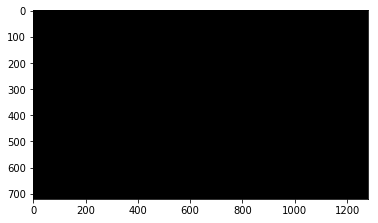

In [110]:
def main():
    img_proc = ImgProcessor()
    # load test image
    img = cv2.imread('test_images/test2.jpg')
    img = img_proc.process_image(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
main()

In [ ]:
video_output = './output_video/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
video_clip = clip1.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)